In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import torch
import random
import numpy as np

# Set seed
torch.manual_seed(7)
torch.cuda.manual_seed(7)
torch.cuda.manual_seed_all(7)
np.random.seed(7)
random.seed(7)

In [ ]:
pip install keras==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 3.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.12.0 which is incompatible.


# **Load the dataset: en (English)**

In [ ]:
from google.colab import drive
# mount your google drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/TFG/AuTexTification/subtask_1/en')

import pandas as pd

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv("train.tsv",  sep='\t', on_bad_lines='skip')
test_df = pd.read_csv("test.tsv",  sep='\t', on_bad_lines='skip')
print('Train dataset size:', train_df.shape)
print('Test dataset size:', test_df.shape)

Train dataset size: (33845, 6)
Test dataset size: (21832, 6)


In [ ]:
# Show the first rows
train_df.head()

,id,prompt,text,label,model,domain
0,12322,you need to stop the,you need to stop the engine and wait until it ...,generated,B,tweets
1,1682,Article 11. On the basis of the information co...,The Commission shall publish the report; an in...,generated,C,legal
2,22592,I have not been tweeting,"I have not been tweeting a lot lately, but I d...",generated,D,tweets
3,17390,NO-PROMPT,I pass my exam and really thankgod for that bu...,human,NO-MODEL,tweets
4,30453,NO-PROMPT,The template will have 3 parts: a mustache sha...,human,NO-MODEL,wiki


In [ ]:
# Since we will only focus on a binary classification, we do not need the id, prompt and model variables
# We will mantain the domain variable to later study how well the model works depending on the domain
train_df = train_df.drop(['id', 'prompt', 'model'], axis=1)
test_df = test_df.drop(['id', 'prompt', 'model'], axis=1)

In [ ]:
train_df.head()

,text,label,domain
0,you need to stop the engine and wait until it ...,generated,tweets
1,The Commission shall publish the report; an in...,generated,legal
2,"I have not been tweeting a lot lately, but I d...",generated,tweets
3,I pass my exam and really thankgod for that bu...,human,tweets
4,The template will have 3 parts: a mustache sha...,human,wiki


## Split the data

In [ ]:
X_train = train_df[['text','domain']]
y_train = train_df['label']
X_test = test_df[['text','domain']]
y_test = test_df['label']

# We will use them later
domains_train = X_train['domain']
domains_test = X_test['domain']

X_train = X_train['text']
X_test = X_test['text']

print('Training dataset size:', len(X_train))
print('Test dataset size:', len(X_test))

Training dataset size: 33845
Test dataset size: 21832


## Label Encoding
Transform the labels to digit format, i.e, 0 : "human"; 1 : "generated".

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

y_train = y_train.tolist()
y_test = y_test.tolist()

le = LabelEncoder()

print("TRAIN DATASET")
print("Before transforming: ", y_train[:10])
y_train = le.fit_transform(y_train)
LABELS = le.classes_
print("After transforming:", y_train[:10])

y_train_cat = to_categorical(y_train)
print("Categorical transforming:", y_train_cat[:10])

print("TEST DATASET")
print("Before transforming: ", y_test[:10])
y_test = le.transform(y_test)
print("After transforming:", y_test[:10])

y_test_cat = to_categorical(y_test)
print("Categorical transforming:", y_test_cat[:10])

label2idx={}
for index, label in enumerate(LABELS):
    label2idx.update([(label, index)])
print('Labels:', label2idx)

TRAIN DATASET
Before transforming:  ['generated', 'generated', 'generated', 'human', 'human', 'generated', 'generated', 'human', 'generated', 'generated']
After transforming: [0 0 0 1 1 0 0 1 0 0]
Categorical transforming: [[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]
TEST DATASET
Before transforming:  ['human', 'human', 'generated', 'human', 'human', 'generated', 'human', 'generated', 'generated', 'human']
After transforming: [1 1 0 1 1 0 1 0 0 1]
Categorical transforming: [[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Labels: {'generated': 0, 'human': 1}


# WORD EMBEDDINGS

In [ ]:
!pip install -q gensim

In [ ]:
import gensim.downloader
for i in list(gensim.downloader.info()['models'].keys()):
  print(i)

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [ ]:
# Store the results for each word embedding
f1_scores = []

For all the following embeddings, we will apply the best model obtained in the CNN notebook, i.e, the 3-layered CNN with parameters 'learning_rate'=0.001, 'kernel'=3, 'filter3'=32, 'filter2'=64, 'filter1'=128, 'embedding_size'=300

## glove-twitter-25

In [ ]:
# import gensim.downloader as api
# model_we = api.load("glove-twitter-25")

In [ ]:
# # dimension of 25
# vector = model_we['trend']
# print(vector.shape)
# print(vector)

Save and Load models

In [ ]:
# model_we.save('twitter25.bin')

In [ ]:
from gensim.models import KeyedVectors
new_model_we = KeyedVectors.load('twitter25.bin')
vector = new_model_we['trend']

### Embedding Matrix

In [ ]:
# ner rows = ner of tokens
X_train = X_train.tolist()
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token = True)
# Train the tokenizer using the texts
tokenizer.fit_on_texts(X_train)

# Use index 0 represents token padding (all texts have same length)
tokenizer.word_index['<PAD>'] = 0

NUM_WORDS=len(tokenizer.word_index)
print("Size of vocabulary = {}".format(NUM_WORDS))

Size of vocabulary = 45686


In [ ]:
from keras.utils import pad_sequences
MAX_LEN=85  # 85 está bien o es muy alto???
# Transform the tokens into a sequence of integer numbers
encoded_train = tokenizer.texts_to_sequences(X_train)
encoded_train_pad = pad_sequences(encoded_train, maxlen = MAX_LEN,
                              padding='post', truncating='post')

In [ ]:
# Embedding size
EMBED_SIZE = vector.shape[0]
print(EMBED_SIZE)
# MATRIX: 45686 x 25
embedding_matrix = np.zeros((NUM_WORDS, EMBED_SIZE))
embedding_matrix

25


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = new_model_we[word]
        # word embedding for word with index i
        embedding_matrix[i] = embedding_vector
    except:
        #if word does not exist, we do not udpate the matrix
        pass

print('matrix created')

embedding_matrix

matrix created


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.010167  ,  0.020194  ,  0.21472999, ...,  0.18783   ,
        -0.84249997, -0.31208   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.2938    ,  0.0058762 ,  1.227     , ..., -0.62234998,
        -0.13311   , -0.26086   ]])

In [ ]:
# Show the first 10 words in the vocabulary
# first row is the token PAD
print(embedding_matrix.shape)
for word, i in tokenizer.word_index.items():
    print(word,  embedding_matrix[i])
    if i==10:
        break

(45686, 25)
True [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
the [-1.01669999e-02  2.01939996e-02  2.14729995e-01  1.72889993e-01
 -4.36589986e-01 -1.46870002e-01  1.84290004e+00 -1.57529995e-01
  1.81869999e-01 -3.17820013e-01  6.83899969e-02  5.17759979e-01
 -6.33710003e+00  4.80659992e-01  1.37769997e-01 -4.85680014e-01
  3.89999986e-01 -1.95059995e-03 -1.02179997e-01  2.12620005e-01
 -8.61459970e-01  1.72629997e-01  1.87830001e-01 -8.42499971e-01
 -3.12079996e-01]
to [ 0.28228     0.019558    0.11509    -0.39241999 -1.0503     -0.54277998
  1.13569999 -0.34251001  0.80636001 -0.47358999 -0.77193999 -0.73689002
 -6.26189995 -0.34902    -0.35532001 -0.60148001 -0.054534   -0.67057002
 -0.39972001 -1.324      -0.43765     0.30045     0.21430001  0.25422001
 -0.26673999]
of [ 0.32543001 -0.089637   -0.14733     0.4285     -0.092613   -0.17938
  1.28349996 -0.59714001 -0.28134    -0.048954    0.54826999  0.69410002
 -6.11999989  0.6724      0.018078   -

In [ ]:
count=0
for word, i in tokenizer.word_index.items():
    if np.all(embedding_matrix[i] == np.zeros((EMBED_SIZE,))):
        count+=1
count

15376

A total of 15376 words do not appear in the vocabulary. Hence, we will use other word embedding libraries with higher dimensions.

### CNN (Convolutional Neural Networks)

#### Build the model

In [ ]:
import tensorflow as tf
tf.random.set_seed(42)

from keras.models import Sequential  # add layer sequentially
from keras.layers import Flatten, Dense, Embedding, Conv1D, MaxPooling1D

from keras.wrappers.scikit_learn import KerasClassifier

from keras.callbacks import ModelCheckpoint, EarlyStopping

model = Sequential()

model.add(Embedding(NUM_WORDS, EMBED_SIZE,
                        input_length=MAX_LEN,
                        weights=[embedding_matrix]))

model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(len(LABELS), activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 85, 25)            1142150   
                                                                 
 conv1d (Conv1D)             (None, 85, 128)           16128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 42, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 42, 64)            32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 21, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 21, 32)            6

#### Train the model

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Stop the training if after 2 epochs the error does not lower
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

In [ ]:
epochs = 5  # ner cycles through the whole dataset
batch_size = 32  #16, 32 ner of samples for each step, each epoch has 33845/32 ~ 1058 steps

# training
history=model.fit(encoded_train_pad,  # preprocessed texts
                  y_train_cat,        # labels
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=0.2,
                  callbacks=[earlyStopping],
                  )

Epoch 1/5
847/847 [==============================] - 52s 54ms/step - loss: 0.5062 - accuracy: 0.7328 - val_loss: 0.4446 - val_accuracy: 0.7772
Epoch 2/5
847/847 [==============================] - 12s 14ms/step - loss: 0.3670 - accuracy: 0.8273 - val_loss: 0.3780 - val_accuracy: 0.8233
Epoch 3/5
847/847 [==============================] - 8s 10ms/step - loss: 0.2706 - accuracy: 0.8838 - val_loss: 0.3933 - val_accuracy: 0.8233
Epoch 4/5
847/847 [==============================] - 8s 9ms/step - loss: 0.1798 - accuracy: 0.9283 - val_loss: 0.4423 - val_accuracy: 0.8187


#### Save model

In [ ]:
model.save("twitter25_model.h5")

# from tensorflow.keras.models import load_model

# # Load the saved model
# loaded_model = load_model("twitter25_model.h5")

#### Learning Curves

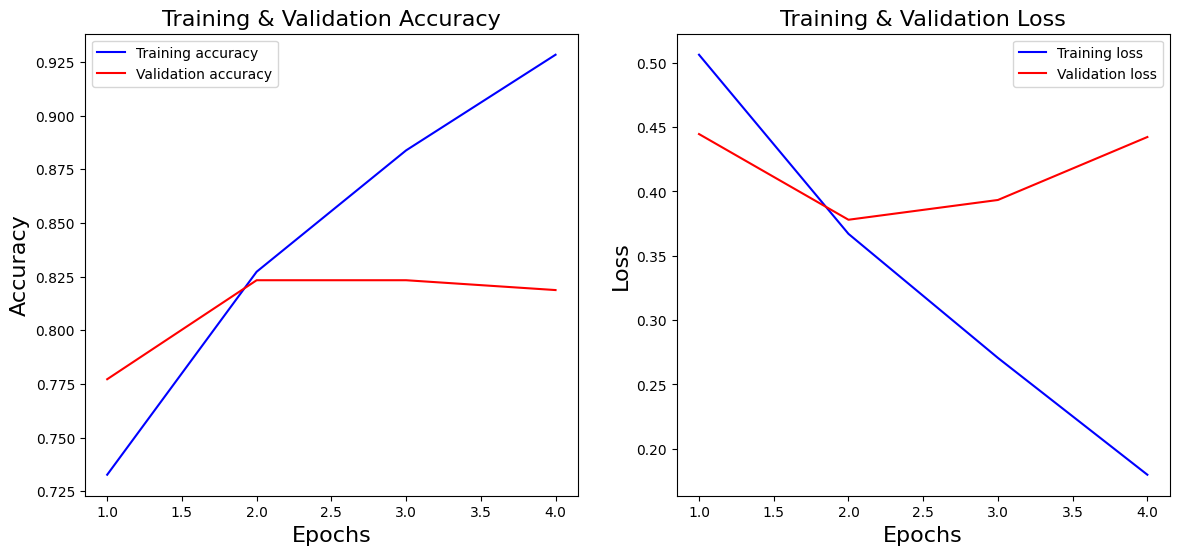

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Accuracy vs Epochs Curve
#
ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'red', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Loss vs Epochs Curve
#
ax[1].plot(epochs, loss_values, 'b', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'red', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

#### Evaluate the model

In [ ]:
X_test = X_test.tolist()
encoded_test = tokenizer.texts_to_sequences(X_test)
encoded_test_pad = pad_sequences(encoded_test, maxlen = MAX_LEN, padding='post')

from sklearn.metrics import accuracy_score, f1_score, classification_report

# Predict with test dataset
y_pred = np.argmax(model.predict(encoded_test_pad), axis=1)

print('accuracy:', accuracy_score(y_test, y_pred))
print('f1 score1:', f1_score(y_test, y_pred, average='macro'))
f1_scores.append(f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred, target_names=LABELS))

683/683 [==============================] - 2s 2ms/step
accuracy: 0.6662696958592891
f1 score1: 0.6462962715896136
              precision    recall  f1-score   support

   generated       0.62      0.88      0.73     11190
       human       0.78      0.44      0.56     10642

    accuracy                           0.67     21832
   macro avg       0.70      0.66      0.65     21832
weighted avg       0.70      0.67      0.65     21832



[[9867 1323]
 [5963 4679]]


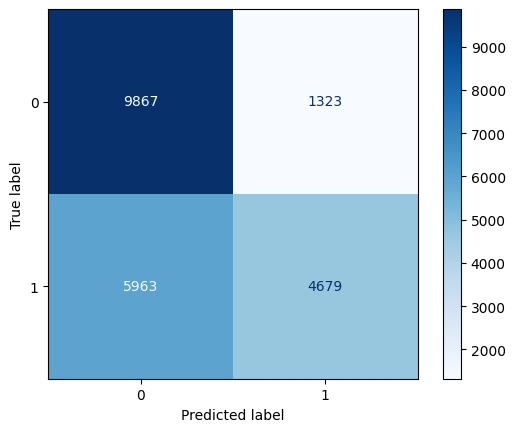

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(confusion_matrix(y_test, y_pred))
disp=ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)

## glove-twitter-200

In [ ]:
# import gensim.downloader as api
# model_we = api.load("glove-twitter-200")

In [ ]:
# # dimension of 200
# vector = model_we['trend']
# print(vector.shape)
# print(vector)

Save and Load models

In [ ]:
# model_we.save('twitter200.bin')

In [ ]:
from gensim.models import KeyedVectors
new_model_we = KeyedVectors.load('twitter200.bin')
vector = new_model_we['trend']

### Embedding Matrix

In [ ]:
# ner rows = ner of tokens
#X_train = X_train.tolist()
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token = True)
# Train the tokenizer using the texts
tokenizer.fit_on_texts(X_train)

# Use index 0 represents token padding (all texts have same length)
tokenizer.word_index['<PAD>'] = 0

NUM_WORDS=len(tokenizer.word_index)
print("Size of vocabulary = {}".format(NUM_WORDS))

Size of vocabulary = 45686


In [ ]:
from keras.utils import pad_sequences
MAX_LEN=85  # 85 está bien o es muy alto???
# Transform the tokens into a sequence of integer numbers
encoded_train = tokenizer.texts_to_sequences(X_train)
encoded_train_pad = pad_sequences(encoded_train, maxlen = MAX_LEN,
                              padding='post', truncating='post')

In [ ]:
# Embedding size
EMBED_SIZE = vector.shape[0]
print(EMBED_SIZE)
# MATRIX: 45686 x 200
embedding_matrix = np.zeros((NUM_WORDS, EMBED_SIZE))
embedding_matrix

200


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = new_model_we[word]
        # word embedding for word with index i
        embedding_matrix[i] = embedding_vector
    except:
        #if word does not exist, we do not udpate the matrix
        pass

print('matrix created')

embedding_matrix

matrix created


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.49349999,  0.35698   ,  0.66068   , ...,  0.17705999,
        -0.53694999, -0.29699001],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.42791   ,  0.24054   ,  0.29460001, ...,  0.37029001,
         0.12612   , -0.44095001]])

In [ ]:
# Show the first 10 words in the vocabulary
# first row is the token PAD
print(embedding_matrix.shape)
for word, i in tokenizer.word_index.items():
    print(word,  embedding_matrix[i])
    if i==10:
        break

(45686, 200)
True [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
the [ 4.93499994e-01  3.56979996e-01  6.60679996e-01 -3.29749994e-02
  2.49890000e-01  2.59359986e-01 -2.71690004e-02  6.84029981e-02
 -2.90630013e-01 -4.57049996e-01 -7.79400021e-02  3.25159997e-01
 -1.48520005e+00 -6.74720034e-02 -1.70330003e-01 -9.29639954e-03
  3.46280009e-01 -1.15750004e-02  3.79649997e-02  4.56169993e-01
  8.04859996e-02  1.53099999e-01 -1.5309000

In [ ]:
count=0
for word, i in tokenizer.word_index.items():
    if np.all(embedding_matrix[i] == np.zeros((EMBED_SIZE,))):
        count+=1
count

15376

A total of 15376 words do not appear in the vocabulary. Hence, we will use other word embedding libraries with higher dimensions.

### CNN (Convolutional Neural Networks)

#### Build the model

In [ ]:
model = Sequential()

model.add(Embedding(NUM_WORDS, EMBED_SIZE,
                        input_length=MAX_LEN,
                        weights=[embedding_matrix]))

model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(len(LABELS), activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 85, 200)           9137200   
                                                                 
 conv1d_3 (Conv1D)           (None, 85, 128)           128128    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 42, 128)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 42, 64)            32832     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 21, 64)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 21, 32)           

#### Train the model

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Stop the training if after 2 epochs the error does not lower
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

In [ ]:
epochs = 5  # ner cycles through the whole dataset
batch_size = 32  #16, 32 ner of samples for each step, each epoch has 33845/32 ~ 1058 steps

# training
history=model.fit(encoded_train_pad,  # preprocessed texts
                  y_train_cat,        # labels
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=0.2,
                  callbacks=[earlyStopping],
                  )

Epoch 1/5
847/847 [==============================] - 48s 55ms/step - loss: 0.4605 - accuracy: 0.7668 - val_loss: 0.4147 - val_accuracy: 0.7985
Epoch 2/5
847/847 [==============================] - 16s 19ms/step - loss: 0.2789 - accuracy: 0.8797 - val_loss: 0.3740 - val_accuracy: 0.8378
Epoch 3/5
847/847 [==============================] - 9s 11ms/step - loss: 0.1266 - accuracy: 0.9510 - val_loss: 0.5039 - val_accuracy: 0.8149
Epoch 4/5
847/847 [==============================] - 11s 12ms/step - loss: 0.0488 - accuracy: 0.9831 - val_loss: 0.6556 - val_accuracy: 0.8233


#### Save model

In [ ]:
model.save("twitter200_model.h5")

# from tensorflow.keras.models import load_model

# # Load the saved model
# loaded_model = load_model("twitter200_model.h5")

#### Learning Curves

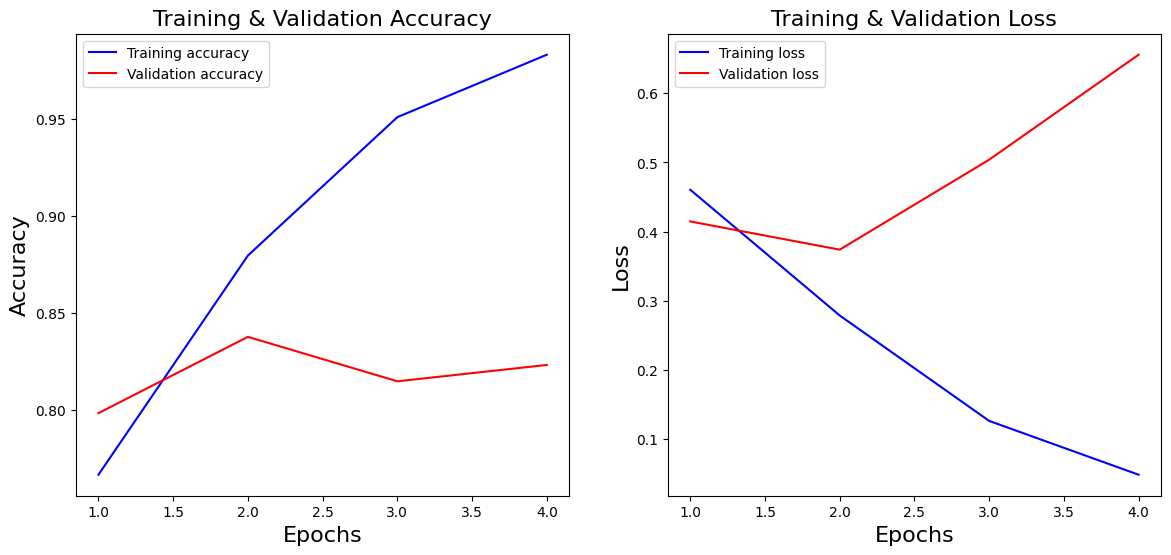

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Accuracy vs Epochs Curve
#
ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'red', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Loss vs Epochs Curve
#
ax[1].plot(epochs, loss_values, 'b', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'red', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

#### Evaluate the model

In [ ]:
#X_test = X_test.tolist()
encoded_test = tokenizer.texts_to_sequences(X_test)
encoded_test_pad = pad_sequences(encoded_test, maxlen = MAX_LEN, padding='post')

from sklearn.metrics import accuracy_score, classification_report

# Predict with test dataset
y_pred = np.argmax(model.predict(encoded_test_pad), axis=1)

print('accuracy:', accuracy_score(y_test, y_pred))
print('f1 score1:', f1_score(y_test, y_pred, average='macro'))
f1_scores.append(f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred, target_names=LABELS))

683/683 [==============================] - 1s 2ms/step
accuracy: 0.6200989373396849
f1 score1: 0.5690197650546059
              precision    recall  f1-score   support

   generated       0.58      0.94      0.72     11190
       human       0.82      0.28      0.42     10642

    accuracy                           0.62     21832
   macro avg       0.70      0.61      0.57     21832
weighted avg       0.70      0.62      0.57     21832



[[10527   663]
 [ 7631  3011]]


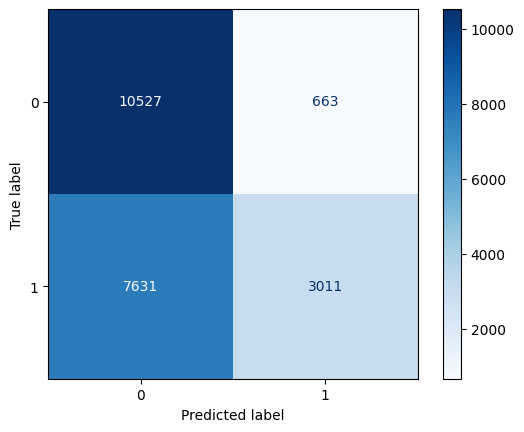

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(confusion_matrix(y_test, y_pred))
disp=ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)

## glove-wiki-gigaword-100

In [ ]:
# import gensim.downloader as api
# model_we = api.load("glove-wiki-gigaword-100")

In [ ]:
# # dimension of 100
# vector = model_we['trend']
# print(vector.shape)
# print(vector)

Save and Load models

In [ ]:
# model_we.save('wiki100.bin')

In [ ]:
from gensim.models import KeyedVectors
new_model_we = KeyedVectors.load('wiki100.bin')
vector = new_model_we['trend']

### Embedding Matrix

In [ ]:
# ner rows = ner of tokens
#X_train = X_train.tolist()
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token = True)
# Train the tokenizer using the texts
tokenizer.fit_on_texts(X_train)

# Use index 0 represents token padding (all texts have same length)
tokenizer.word_index['<PAD>'] = 0

NUM_WORDS=len(tokenizer.word_index)
print("Size of vocabulary = {}".format(NUM_WORDS))

Size of vocabulary = 45686


In [ ]:
from keras.utils import pad_sequences
MAX_LEN=85  # 85 está bien o es muy alto???
# Transform the tokens into a sequence of integer numbers
encoded_train = tokenizer.texts_to_sequences(X_train)
encoded_train_pad = pad_sequences(encoded_train, maxlen = MAX_LEN,
                              padding='post', truncating='post')

In [ ]:
# Embedding size
EMBED_SIZE = vector.shape[0]
print(EMBED_SIZE)
# MATRIX: 45686 x 100
embedding_matrix = np.zeros((NUM_WORDS, EMBED_SIZE))
embedding_matrix

100


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = new_model_we[word]
        # word embedding for word with index i
        embedding_matrix[i] = embedding_vector
    except:
        #if word does not exist, we do not udpate the matrix
        pass

print('matrix created')

embedding_matrix

matrix created


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.51618999, -0.29099   ,  0.020343  , ...,  0.57416999,
        -0.49950001, -0.92537999],
       [-0.060746  , -0.58302999, -0.26012999, ..., -0.76985002,
        -0.73802   ,  0.18355   ]])

In [ ]:
# Show the first 10 words in the vocabulary
# first row is the token PAD
print(embedding_matrix.shape)
for word, i in tokenizer.word_index.items():
    print(word,  embedding_matrix[i])
    if i==10:
        break

(45686, 100)
True [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
the [-0.038194   -0.24487001  0.72812003 -0.39961001  0.083172    0.043953
 -0.39140999  0.3344     -0.57545     0.087459    0.28786999 -0.06731
  0.30906001 -0.26383999 -0.13231    -0.20757     0.33395001 -0.33848
 -0.31742999 -0.48335999  0.1464     -0.37303999  0.34577     0.052041
  0.44946    -0.46970999  0.02628    -0.54154998 -0.15518001 -0.14106999
 -0.039722    0.28277001  0.14393     0.23464    -0.31020999  0.086173
  0.20397     0.52623999  0.17163999 -0.082378   -0.71787    -0.41531
  0.20334999 -0.12763     0.41367     0.55186999  0.57907999 -0.33476999
 -0.36559001 -0.54856998 -0.062892    0.26583999  0.30204999  0.99774998
 -0.80480999 -3.0243001   0.01

In [ ]:
count=0
for word, i in tokenizer.word_index.items():
    if np.all(embedding_matrix[i] == np.zeros((EMBED_SIZE,))):
        count+=1
count

12618

A total of 12618 words do not appear in the vocabulary. Hence, we will use other word embedding libraries with higher dimensions.

### CNN (Convolutional Neural Networks)

#### Build the model

In [ ]:
model = Sequential()

model.add(Embedding(NUM_WORDS, EMBED_SIZE,
                        input_length=MAX_LEN,
                        weights=[embedding_matrix]))

model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(len(LABELS), activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 85, 100)           4568600   
                                                                 
 conv1d_6 (Conv1D)           (None, 85, 128)           64128     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 42, 128)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 42, 64)            32832     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 21, 64)           0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 21, 32)           

#### Train the model

In [ ]:
epochs = 5  # ner cycles through the whole dataset
batch_size = 32  #16, 32 ner of samples for each step, each epoch has 33845/32 ~ 1058 steps

# training
history=model.fit(encoded_train_pad,  # preprocessed texts
                  y_train_cat,        # labels
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=0.2,
                  callbacks=[earlyStopping],
                  )

Epoch 1/5
847/847 [==============================] - 50s 56ms/step - loss: 0.4948 - accuracy: 0.7450 - val_loss: 0.4071 - val_accuracy: 0.8078
Epoch 2/5
847/847 [==============================] - 14s 16ms/step - loss: 0.3200 - accuracy: 0.8565 - val_loss: 0.3686 - val_accuracy: 0.8366
Epoch 3/5
847/847 [==============================] - 9s 11ms/step - loss: 0.1907 - accuracy: 0.9223 - val_loss: 0.3963 - val_accuracy: 0.8326
Epoch 4/5
847/847 [==============================] - 8s 10ms/step - loss: 0.0886 - accuracy: 0.9666 - val_loss: 0.5773 - val_accuracy: 0.8264


#### Save model

In [ ]:
model.save("wiki100_model.h5")

# from tensorflow.keras.models import load_model

# # Load the saved model
# loaded_model = load_model("wiki100_model.h5")

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Stop the training if after 2 epochs the error does not lower
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

#### Learning Curves

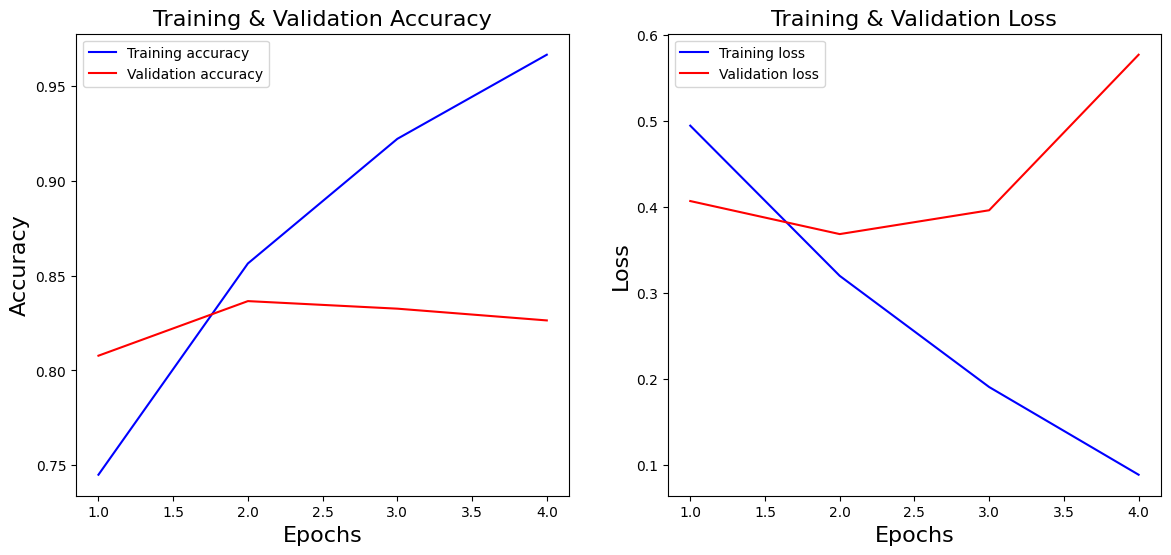

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Accuracy vs Epochs Curve
#
ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'red', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Loss vs Epochs Curve
#
ax[1].plot(epochs, loss_values, 'b', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'red', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

#### Evaluate the model

In [ ]:
#X_test = X_test.tolist()
encoded_test = tokenizer.texts_to_sequences(X_test)
encoded_test_pad = pad_sequences(encoded_test, maxlen = MAX_LEN, padding='post')

from sklearn.metrics import accuracy_score, classification_report

# Predict with test dataset
y_pred = np.argmax(model.predict(encoded_test_pad), axis=1)

print('accuracy:', accuracy_score(y_test, y_pred))
print('f1 score1:', f1_score(y_test, y_pred, average='macro'))
f1_scores.append(f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred, target_names=LABELS))

683/683 [==============================] - 2s 2ms/step
accuracy: 0.6827592524734335
f1 score1: 0.6711030677577512
              precision    recall  f1-score   support

   generated       0.64      0.85      0.73     11190
       human       0.76      0.51      0.61     10642

    accuracy                           0.68     21832
   macro avg       0.70      0.68      0.67     21832
weighted avg       0.70      0.68      0.67     21832



[[9508 1682]
 [5244 5398]]


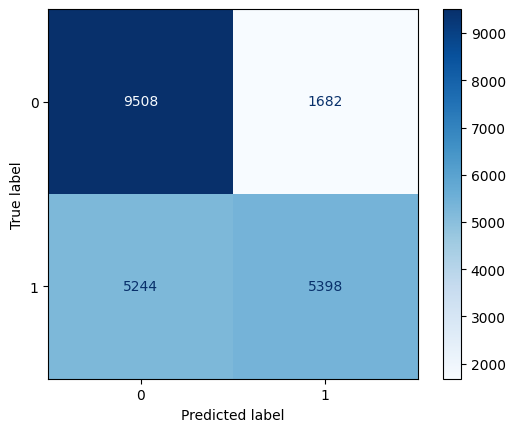

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(confusion_matrix(y_test, y_pred))
disp=ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)

## glove-wiki-gigaword-200

In [ ]:
# import gensim.downloader as api
# model_we = api.load("glove-wiki-gigaword-200")

In [ ]:
# # dimension of 200
# vector = model_we['trend']
# print(vector.shape)
# print(vector)

Save and Load models

In [ ]:
# model_we.save('wiki200.bin')

In [ ]:
from gensim.models import KeyedVectors
new_model_we = KeyedVectors.load('wiki200.bin')
vector = new_model_we['trend']

### Embedding Matrix

In [ ]:
# ner rows = ner of tokens
#X_train = X_train.tolist()
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token = True)
# Train the tokenizer using the texts
tokenizer.fit_on_texts(X_train)

# Use index 0 represents token padding (all texts have same length)
tokenizer.word_index['<PAD>'] = 0

NUM_WORDS=len(tokenizer.word_index)
print("Size of vocabulary = {}".format(NUM_WORDS))

Size of vocabulary = 45686


In [ ]:
from keras.utils import pad_sequences
MAX_LEN=85  # 85 está bien o es muy alto???
# Transform the tokens into a sequence of integer numbers
encoded_train = tokenizer.texts_to_sequences(X_train)
encoded_train_pad = pad_sequences(encoded_train, maxlen = MAX_LEN,
                              padding='post', truncating='post')

In [ ]:
# Embedding size
EMBED_SIZE = vector.shape[0]
print(EMBED_SIZE)
# MATRIX: 45686 x 200
embedding_matrix = np.zeros((NUM_WORDS, EMBED_SIZE))
embedding_matrix

200


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = new_model_we[word]
        # word embedding for word with index i
        embedding_matrix[i] = embedding_vector
    except:
        #if word does not exist, we do not udpate the matrix
        pass

print('matrix created')

embedding_matrix

matrix created


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.071549  ,  0.093459  ,  0.023738  , ...,  0.33616999,
         0.030591  ,  0.25577   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.010771  , -0.52412999, -0.23833001, ..., -0.018635  ,
         0.23541   , -0.61211002],
       [-0.16529   , -0.086321  , -0.78900999, ..., -0.032941  ,
         0.55646002, -0.49470001]])

In [ ]:
# Show the first 10 words in the vocabulary
# first row is the token PAD
print(embedding_matrix.shape)
for word, i in tokenizer.word_index.items():
    print(word,  embedding_matrix[i])
    if i==10:
        break

(45686, 200)
True [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
the [-7.15489984e-02  9.34590027e-02  2.37380005e-02 -9.03389975e-02
  5.61229996e-02  3.25470001e-01 -3.97960007e-01 -9.21389982e-02
  6.11810014e-02 -1.89500004e-01  1.30610004e-01  1.43490002e-01
  1.14789996e-02  3.81579995e-01  5.40300012e-01 -1.40880004e-01
  2.43149996e-01  2.30360001e-01 -5.53390026e-01  4.81540002e-02
  4.56620008e-01  3.23379993e+00  2.0199000

In [ ]:
count=0
for word, i in tokenizer.word_index.items():
    if np.all(embedding_matrix[i] == np.zeros((EMBED_SIZE,))):
        count+=1
count

12618

A total of 12618 words do not appear in the vocabulary. Hence, we will use other word embedding libraries with higher dimensions.

### CNN (Convolutional Neural Networks)

#### Build the model

In [ ]:
model = Sequential()

model.add(Embedding(NUM_WORDS, EMBED_SIZE,
                        input_length=MAX_LEN,
                        weights=[embedding_matrix]))

model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(len(LABELS), activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 85, 200)           9137200   
                                                                 
 conv1d_9 (Conv1D)           (None, 85, 128)           128128    
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 42, 128)          0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 42, 64)            32832     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 21, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 21, 32)           

#### Train the model

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Stop the training if after 2 epochs the error does not lower
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

In [ ]:
epochs = 5  # ner cycles through the whole dataset
batch_size = 32  #16, 32 ner of samples for each step, each epoch has 33845/32 ~ 1058 steps

# training
history=model.fit(encoded_train_pad,  # preprocessed texts
                  y_train_cat,        # labels
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=0.2,
                  callbacks=[earlyStopping],
                  )

Epoch 1/5
847/847 [==============================] - 32s 36ms/step - loss: 0.4748 - accuracy: 0.7553 - val_loss: 0.4077 - val_accuracy: 0.8046
Epoch 2/5
847/847 [==============================] - 12s 14ms/step - loss: 0.2973 - accuracy: 0.8717 - val_loss: 0.3698 - val_accuracy: 0.8342
Epoch 3/5
847/847 [==============================] - 9s 10ms/step - loss: 0.1443 - accuracy: 0.9424 - val_loss: 0.4575 - val_accuracy: 0.8189
Epoch 4/5
847/847 [==============================] - 8s 10ms/step - loss: 0.0584 - accuracy: 0.9792 - val_loss: 0.6180 - val_accuracy: 0.8150


#### Save model

In [ ]:
model.save("wiki200_model.h5")

# from tensorflow.keras.models import load_model

# # Load the saved model
# loaded_model = load_model("wiki200_model.h5")

#### Learning Curves

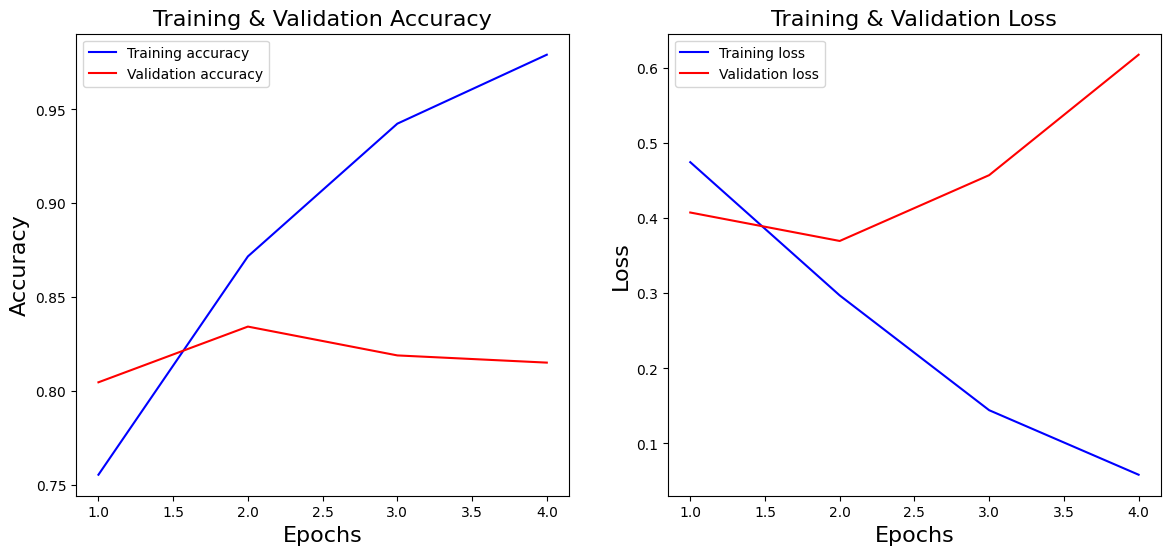

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Accuracy vs Epochs Curve
#
ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'red', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Loss vs Epochs Curve
#
ax[1].plot(epochs, loss_values, 'b', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'red', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

#### Evaluate the model

In [ ]:
#X_test = X_test.tolist()
encoded_test = tokenizer.texts_to_sequences(X_test)
encoded_test_pad = pad_sequences(encoded_test, maxlen = MAX_LEN, padding='post')

from sklearn.metrics import accuracy_score, classification_report

# Predict with test dataset
y_pred = np.argmax(model.predict(encoded_test_pad), axis=1)

print('accuracy:', accuracy_score(y_test, y_pred))
print('f1 score1:', f1_score(y_test, y_pred, average='macro'))
f1_scores.append(f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred, target_names=LABELS))

683/683 [==============================] - 1s 2ms/step
accuracy: 0.6284353242946135
f1 score1: 0.5888530834656462
              precision    recall  f1-score   support

   generated       0.59      0.92      0.72     11190
       human       0.79      0.33      0.46     10642

    accuracy                           0.63     21832
   macro avg       0.69      0.62      0.59     21832
weighted avg       0.68      0.63      0.59     21832



[[10247   943]
 [ 7169  3473]]


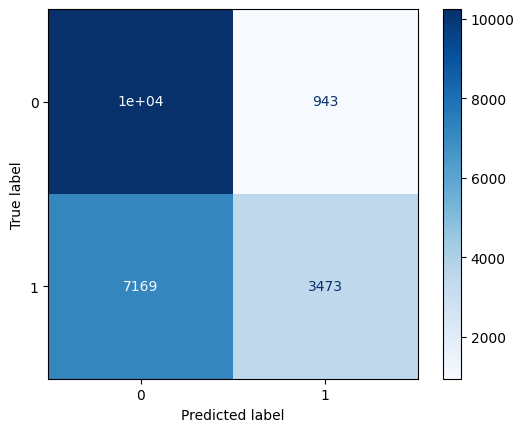

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(confusion_matrix(y_test, y_pred))
disp=ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)

## glove-wiki-gigaword-300

In [ ]:
# import gensim.downloader as api
# model_we = api.load("glove-wiki-gigaword-300")

In [ ]:
# # dimension of 300
# vector = model_we['trend']
# print(vector.shape)
# print(vector)

Save and Load models

In [ ]:
# model_we.save('wiki300.bin')

In [ ]:
from gensim.models import KeyedVectors
new_model_we = KeyedVectors.load('wiki300.bin')
vector = new_model_we['trend']

### Embedding Matrix

In [ ]:
# ner rows = ner of tokens
#X_train = X_train.tolist()
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token = True)
# Train the tokenizer using the texts
tokenizer.fit_on_texts(X_train)

# Use index 0 represents token padding (all texts have same length)
tokenizer.word_index['<PAD>'] = 0

NUM_WORDS=len(tokenizer.word_index)
print("Size of vocabulary = {}".format(NUM_WORDS))

Size of vocabulary = 45686


In [ ]:
from keras.utils import pad_sequences
MAX_LEN=85  # 85 está bien o es muy alto???
# Transform the tokens into a sequence of integer numbers
encoded_train = tokenizer.texts_to_sequences(X_train)
encoded_train_pad = pad_sequences(encoded_train, maxlen = MAX_LEN,
                              padding='post', truncating='post')

In [ ]:
# Embedding size
EMBED_SIZE = vector.shape[0]
print(EMBED_SIZE)
# MATRIX: 45686 x 300
embedding_matrix = np.zeros((NUM_WORDS, EMBED_SIZE))
embedding_matrix

300


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = new_model_we[word]
        # word embedding for word with index i
        embedding_matrix[i] = embedding_vector
    except:
        #if word does not exist, we do not udpate the matrix
        pass

print('matrix created')

embedding_matrix

matrix created


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04656   ,  0.21318001, -0.0074364 , ...,  0.0090611 ,
        -0.20988999,  0.053913  ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.080732  , -0.10412   , -0.096533  , ...,  0.16594   ,
         0.51008999,  0.087887  ],
       [-0.017268  ,  0.17918999, -0.006189  , ...,  0.48965001,
        -0.36798   ,  0.41161999]])

In [ ]:
# Show the first 10 words in the vocabulary
# first row is the token PAD
print(embedding_matrix.shape)
for word, i in tokenizer.word_index.items():
    print(word,  embedding_matrix[i])
    if i==10:
        break

(45686, 300)
True [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
the [ 4.65600006e-02  2.13180006e-01 -7.43639981e-03 -4.58539993e-01

In [ ]:
count=0
for word, i in tokenizer.word_index.items():
    if np.all(embedding_matrix[i] == np.zeros((EMBED_SIZE,))):
        count+=1
count

12618

A total of 12618 words do not appear in the vocabulary. Hence, we will use other word embedding libraries with higher dimensions.

### CNN (Convolutional Neural Networks)

#### Build the model

In [ ]:
model = Sequential()

model.add(Embedding(NUM_WORDS, EMBED_SIZE,
                        input_length=MAX_LEN,
                        weights=[embedding_matrix]))

model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(len(LABELS), activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 85, 300)           13705800  
                                                                 
 conv1d_12 (Conv1D)          (None, 85, 128)           192128    
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 42, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 42, 64)            32832     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 21, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 21, 32)           

#### Train the model

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Stop the training if after 2 epochs the error does not lower
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

In [ ]:
epochs = 5  # ner cycles through the whole dataset
batch_size = 32  #16, 32 ner of samples for each step, each epoch has 33845/32 ~ 1058 steps

# training
history=model.fit(encoded_train_pad,  # preprocessed texts
                  y_train_cat,        # labels
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=0.2,
                  callbacks=[earlyStopping],
                  )

Epoch 1/5
847/847 [==============================] - 51s 58ms/step - loss: 0.4689 - accuracy: 0.7613 - val_loss: 0.3933 - val_accuracy: 0.8156
Epoch 2/5
847/847 [==============================] - 15s 18ms/step - loss: 0.2772 - accuracy: 0.8794 - val_loss: 0.3784 - val_accuracy: 0.8289
Epoch 3/5
847/847 [==============================] - 11s 13ms/step - loss: 0.1170 - accuracy: 0.9540 - val_loss: 0.4965 - val_accuracy: 0.8128
Epoch 4/5
847/847 [==============================] - 11s 13ms/step - loss: 0.0447 - accuracy: 0.9836 - val_loss: 0.7612 - val_accuracy: 0.8134


#### Save model

In [ ]:
model.save("wiki300_model.h5")

# from tensorflow.keras.models import load_model

# # Load the saved model
# loaded_model = load_model("wiki300_model.h5")

#### Learning Curves

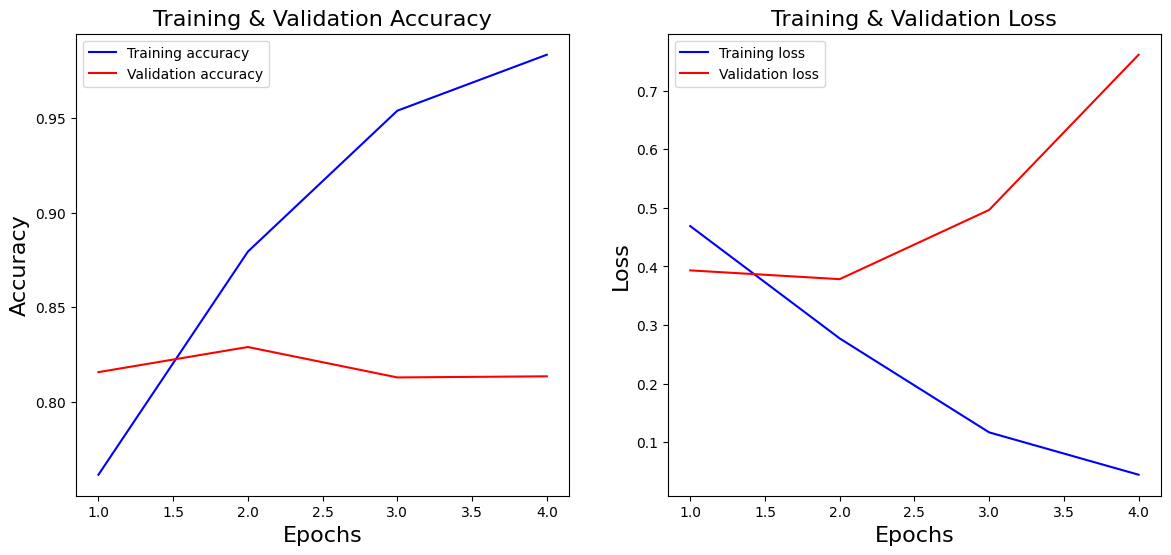

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Accuracy vs Epochs Curve
#
ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'red', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Loss vs Epochs Curve
#
ax[1].plot(epochs, loss_values, 'b', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'red', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

#### Evaluate the model

In [ ]:
#X_test = X_test.tolist()
encoded_test = tokenizer.texts_to_sequences(X_test)
encoded_test_pad = pad_sequences(encoded_test, maxlen = MAX_LEN, padding='post')

from sklearn.metrics import accuracy_score, classification_report

# Predict with test dataset
y_pred = np.argmax(model.predict(encoded_test_pad), axis=1)

print('accuracy:', accuracy_score(y_test, y_pred))
print('f1 score1:', f1_score(y_test, y_pred, average='macro'))
f1_scores.append(f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred, target_names=LABELS))

683/683 [==============================] - 2s 2ms/step
accuracy: 0.6574752656650787
f1 score1: 0.6356791291087731
              precision    recall  f1-score   support

   generated       0.62      0.88      0.72     11190
       human       0.77      0.42      0.55     10642

    accuracy                           0.66     21832
   macro avg       0.69      0.65      0.64     21832
weighted avg       0.69      0.66      0.64     21832



[[9847 1343]
 [6135 4507]]


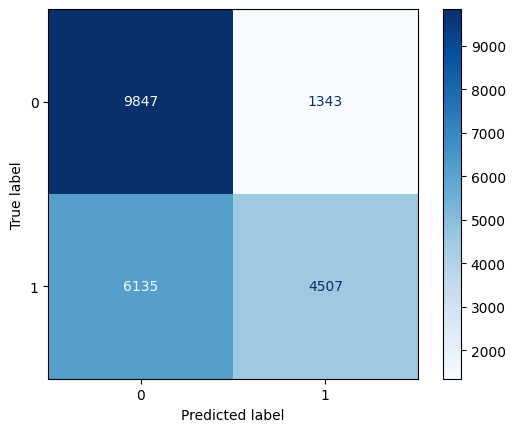

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(confusion_matrix(y_test, y_pred))
disp=ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)

## F1-score results

In [ ]:
# results = pd.DataFrame({'glove-twitter-25':twitter_25, 'glove-twitter-200':twitter_200, 'glove-wiki-gigaword-100':giga_100, 'glove-wiki-gigaword-200':giga_200, 'glove-wiki-gigaword-300':giga_300})

In [ ]:
results = pd.DataFrame({'f1_score':f1_scores})
results.index = ['glove-twitter-25', 'glove-twitter-200', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300']
results

,f1_score
glove-twitter-25,0.646296
glove-twitter-200,0.569020
glove-wiki-gigaword-100,0.671103
glove-wiki-gigaword-200,0.588853
glove-wiki-gigaword-300,0.635679


We can see that the best results are obtained with 'glove-wiki-gigaword100'.

We will use this word embedding for creating the best model and obtaining the predictions for each embedding.

## Per domain giga-wiki-100



#### Load giga-wiki-100 model

In [ ]:
from gensim.models import KeyedVectors
model_we = KeyedVectors.load('wiki100.bin')   # already created when computing the best embedding

# dimension of 100
vector = model_we['trend']
# print(vector.shape)
# print(vector)

### Embedding Matrix

In [ ]:
# ner rows = ner of tokens
#X_train = X_train.tolist()

from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(oov_token = True)
# Train the tokenizer using the texts
tokenizer.fit_on_texts(X_train)

# Use index 0 represents token padding (all texts have same length)
tokenizer.word_index['<PAD>'] = 0

NUM_WORDS=len(tokenizer.word_index)
print("Size of vocabulary = {}".format(NUM_WORDS))

Size of vocabulary = 45686


In [ ]:
from keras.utils import pad_sequences
MAX_LEN=85  # 85 está bien o es muy alto???
# Transform the tokens into a sequence of integer numbers
encoded_train = tokenizer.texts_to_sequences(X_train)
encoded_train_pad = pad_sequences(encoded_train, maxlen = MAX_LEN,
                              padding='post', truncating='post')

In [ ]:
# Embedding size
EMBED_SIZE = vector.shape[0]
print(EMBED_SIZE)
# MATRIX: 45686 x 100
embedding_matrix = np.zeros((NUM_WORDS, EMBED_SIZE))
embedding_matrix

100


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = new_model_we[word]
        # word embedding for word with index i
        embedding_matrix[i] = embedding_vector
    except:
        #if word does not exist, we do not udpate the matrix
        pass

print('matrix created')

embedding_matrix

matrix created


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Show the first 10 words in the vocabulary
# first row is the token PAD
print(embedding_matrix.shape)
for word, i in tokenizer.word_index.items():
    print(word,  embedding_matrix[i])
    if i==10:
        break

(45686, 100)
True [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
the [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
to [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
of [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [ ]:
count=0
for word, i in tokenizer.word_index.items():
    if np.all(embedding_matrix[i] == np.zeros((EMBED_SIZE,))):
        count+=1
count

45686

A total of 12618 words do not appear in the vocabulary. Hence, we will use other word embedding libraries with higher dimensions.

### CNN (Convolutional Neural Networks)

#### Build the model

In [ ]:
import tensorflow as tf
tf.random.set_seed(42)

from keras.models import Sequential  # add layer sequentially
from keras.layers import Flatten, Dense, Embedding, Conv1D, MaxPooling1D

from keras.wrappers.scikit_learn import KerasClassifier

from keras.callbacks import ModelCheckpoint, EarlyStopping

model = Sequential()

model.add(Embedding(NUM_WORDS, EMBED_SIZE,
                        input_length=MAX_LEN,
                        weights=[embedding_matrix]))

model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(len(LABELS), activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 85, 100)           4568600   
                                                                 
 conv1d_15 (Conv1D)          (None, 85, 128)           64128     
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 42, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_16 (Conv1D)          (None, 42, 64)            32832     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 21, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (None, 21, 32)           

#### Train the model

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Stop the training if after 2 epochs the error does not lower
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

In [ ]:
epochs = 5  # ner cycles through the whole dataset
batch_size = 32  #16, 32 ner of samples for each step, each epoch has 33845/32 ~ 1058 steps

# training
history=model.fit(encoded_train_pad,  # preprocessed texts
                  y_train_cat,        # labels
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=0.2,
                  callbacks=[earlyStopping],
                  )

Epoch 1/5
847/847 [==============================] - 33s 36ms/step - loss: 0.6932 - accuracy: 0.5038 - val_loss: 0.6932 - val_accuracy: 0.4999
Epoch 2/5
847/847 [==============================] - 11s 13ms/step - loss: 0.6931 - accuracy: 0.5043 - val_loss: 0.6932 - val_accuracy: 0.4999
Epoch 3/5
847/847 [==============================] - 7s 9ms/step - loss: 0.6931 - accuracy: 0.5026 - val_loss: 0.6932 - val_accuracy: 0.4999
Epoch 4/5
847/847 [==============================] - 8s 10ms/step - loss: 0.6931 - accuracy: 0.5049 - val_loss: 0.6931 - val_accuracy: 0.5001
Epoch 5/5
847/847 [==============================] - 8s 10ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.4999


#### Evaluate the model

In [ ]:
#X_test = X_test.tolist() # remove this????????
encoded_test = tokenizer.texts_to_sequences(X_test)
encoded_test_pad = pad_sequences(encoded_test, maxlen = MAX_LEN, padding='post')

from sklearn.metrics import accuracy_score, f1_score, classification_report

# Predict with test dataset
y_pred = np.argmax(model.predict(encoded_test_pad), axis=1)

print('accuracy:', accuracy_score(y_test, y_pred))
print('f1 score1:', f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred, target_names=LABELS))

683/683 [==============================] - 1s 2ms/step
accuracy: 0.487449615243679
f1 score1: 0.32770832050255594
              precision    recall  f1-score   support

   generated       0.00      0.00      0.00     11190
       human       0.49      1.00      0.66     10642

    accuracy                           0.49     21832
   macro avg       0.24      0.50      0.33     21832
weighted avg       0.24      0.49      0.32     21832



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[    0 11190]
 [    0 10642]]


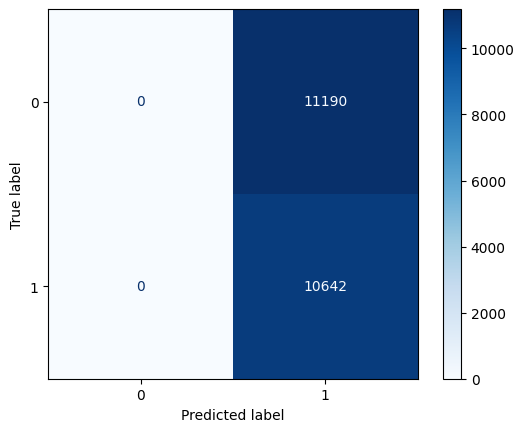

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(confusion_matrix(y_test, y_pred))
disp=ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)

##### Evaluation for each Domain in Test dataset

We will evaluate the performance of the CNN model for each of the domains 'news' and 'reviews'.

In [ ]:
X_test_news = [X_test[i] for i in range(len(X_test)) if domains_test[i] == 'news']
encoded_test_news = tokenizer.texts_to_sequences(X_test_news)
encoded_test_pad_news = pad_sequences(encoded_test_news, maxlen = MAX_LEN, padding='post')
y_test_news = y_test[domains_test=='news']

# Predict with test dataset with domain 'news'
y_pred_news = np.round(model.predict(encoded_test_pad_news))
print('accuracy:', accuracy_score(y_test_news, y_pred_news))
print(classification_report(y_test_news, y_pred_news, target_names=LABELS))
print(confusion_matrix(y_test_news, y_pred_news))
disp=ConfusionMatrixDisplay.from_predictions(y_test_news, y_pred_news, cmap=plt.cm.Blues)

342/342 [==============================] - 1s 2ms/step


ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

We observe that the model categorizes incorrectly more than half of the texts written by a human in the news domain.

Moreover, the macro F1s-score is 0.56.

In [ ]:
y_test_news

In [ ]:
y_pred_news

In [ ]:
X_test_reviews = [X_test[i] for i in range(len(X_test)) if domains_test[i] == 'reviews']
encoded_test_reviews = tokenizer.texts_to_sequences(X_test_reviews)
encoded_test_pad_reviews = pad_sequences(encoded_test_reviews, maxlen = MAX_LEN, padding='post')
y_test_reviews = y_test[domains_test=='reviews']

# Predict with test dataset with domain 'reviews'
y_pred_reviews = np.round(model.predict(encoded_test_pad_reviews))
print('accuracy:', accuracy_score(y_test_reviews, y_pred_reviews))
print(classification_report(y_test_reviews, y_pred_reviews, target_names=LABELS))
print(confusion_matrix(y_test_reviews, y_pred_reviews))
disp=ConfusionMatrixDisplay.from_predictions(y_test_reviews, y_pred_reviews, cmap=plt.cm.Blues)

For the texts written by a human in the reviews texts, we see that it does slightly better but still gives many false negatives.

Moreover, the  macro F1s-score is 0.64.